In [1]:
from db_connection import create_connection, query_data, query_sql_file, select_table
from preprocessing import process_vital_signs, process_diagnoses, process_pain

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Connect to MIMIC-III database
con = create_connection()

In [4]:
img_path = '../data_viz_img/vital_signs/'
dataset_path = '../dataset/'

### Pain Level (Score) monitored each hour for the 1st day of admission

In [5]:
script = query_sql_file('../sql_scripts/pain_level.sql', con)
df = query_data(script[0], con)
df.head()

,hadm_id,icustay_id,chart_hour,valuenum
0,100007,217937,2145-03-31 20:00:00,5-Moderate
1,100007,217937,2145-03-31 22:00:00,5-Moderate
2,100007,217937,2145-03-31 23:00:00,2-Mild
3,100007,217937,2145-04-01 00:00:00,2-Mild
4,100007,217937,2145-04-01 01:00:00,2-Mild


In [6]:
# Get the admission time for each hadm_id
query = \
"""
SELECT hadm_id, admittime, hospital_expire_flag
FROM admissions;
"""
admissions = query_data(query, con)

In [7]:
df = pd.merge(df, admissions, on=['hadm_id'], how='left')

# Calculate the hour since admission instead of the actual datetime
df['hours_since_admission'] = (df['chart_hour'] - df['admittime']).dt.total_seconds() // 3600

df.drop(columns=['chart_hour', 'admittime'], inplace=True)

df['hours_since_admission'] = df['hours_since_admission'].astype('int')
df.head()

,hadm_id,icustay_id,valuenum,hospital_expire_flag,hours_since_admission
0,100007,217937,5-Moderate,0,14
1,100007,217937,5-Moderate,0,16
2,100007,217937,2-Mild,0,17
3,100007,217937,2-Mild,0,18
4,100007,217937,2-Mild,0,19


#### Pre-process pain score & chart hour

In [8]:
df.dropna(subset=['valuenum'], inplace=True)
df.valuenum = df.valuenum.astype('string')
df.rename(columns={'valuenum': 'pain_score'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146744 entries, 0 to 147120
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   hadm_id                146744 non-null  int64 
 1   icustay_id             146744 non-null  int64 
 2   pain_score             146744 non-null  string
 3   hospital_expire_flag   146744 non-null  int64 
 4   hours_since_admission  146744 non-null  int32 
dtypes: int32(1), int64(3), string(1)
memory usage: 6.2 MB


In [9]:
df['pain_score'] = df['pain_score'].apply(process_pain.pain_score_conversion)
df.head()

,hadm_id,icustay_id,pain_score,hospital_expire_flag,hours_since_admission
0,100007,217937,5.0,0,14
1,100007,217937,5.0,0,16
2,100007,217937,2.0,0,17
3,100007,217937,2.0,0,18
4,100007,217937,2.0,0,19


In [10]:
# For multiple monitored levels per hour, take the average
df = df.groupby(['hadm_id', 'icustay_id', 'hours_since_admission'], as_index=False).agg({
    'pain_score': 'mean',
    'hospital_expire_flag': 'max'
})
df.head()

,hadm_id,icustay_id,hours_since_admission,pain_score,hospital_expire_flag
0,100007,217937,14,5.0,0
1,100007,217937,16,5.0,0
2,100007,217937,17,2.0,0
3,100007,217937,18,2.0,0
4,100007,217937,19,2.0,0


In [11]:
df.hours_since_admission.unique()

array([  14,   16,   17, ...,  832, 1517,  758])

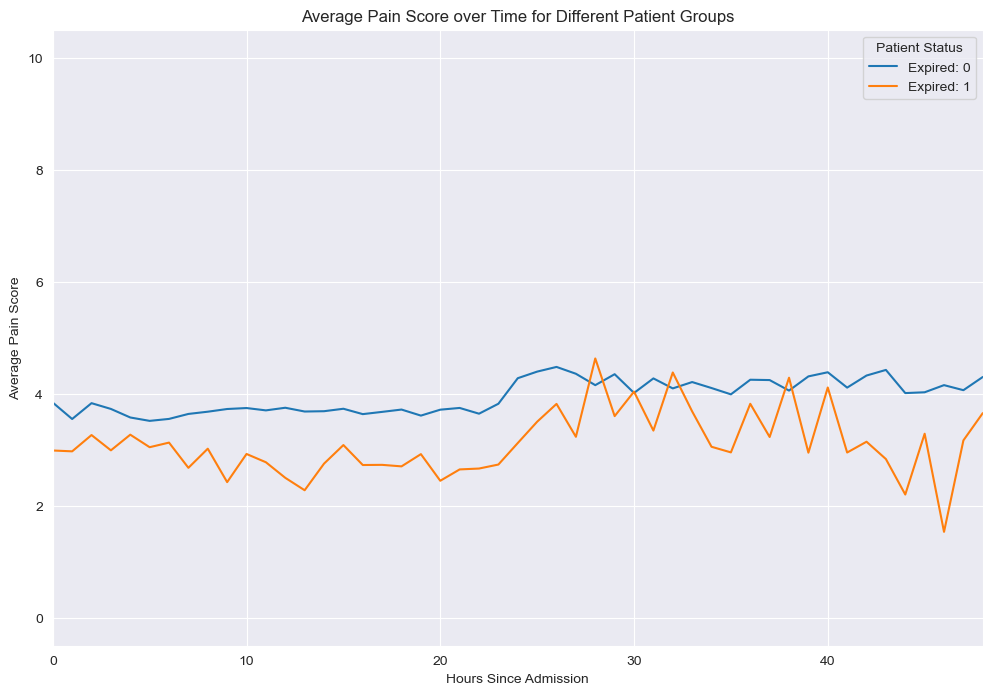

In [12]:
grouped_df = df.groupby(['hospital_expire_flag', 'hours_since_admission'])['pain_score'].mean().reset_index()

plt.figure(figsize=(12, 8))

for label, group in grouped_df.groupby('hospital_expire_flag'):
    plt.plot(group['hours_since_admission'], group['pain_score'], label=f'Expired: {label}')

plt.xlabel('Hours Since Admission')
plt.ylabel('Average Pain Score')
plt.title('Average Pain Score over Time for Different Patient Groups')
plt.legend(title='Patient Status')
plt.xlim([0, 48])

plt.savefig(f'{img_path}05_Average Pain Score over 48h.png')
plt.show()

In [13]:
# df.to_csv('../dataset/pain_level_per_hour.csv')